# Исследовательский анализ данных и  проверка гипотез Яндекс.Афиша.

- Автор: Алмаева Татьяна
- Дата: 04.12.25

## Цели и задачи

**Цель:** Проовести исследовательский и статистический анализ данных Яндекс.Афиши на период с 1 июня по 30 октября 2024 года.

**Задачи**:
1. Загрузить данные и познакомиться с их содержимым.
2. Провести предобработку данных.
    - проверить данные на пропуски;
    - изучить значения в ключевых столбцах;
    - создайть несколько новых столбцов.
3. Провести исследовательский анализ данных:
    - проанализировать распределения заказов по сегментам и их сезонные изменения;
    - изучить осеннюю активность пользователей;
    - изучить популярные события и партнёров.
4. Провести статистический анализ данных.
5. Сформулировать выводы по проведённому анализу.


## Описание данных

В нашем распоряжении 3 датасета:

Первый датасет `final_tickets_orders_df.csv` включает информацию обо всех заказах билетов, совершённых с двух типов устройств — мобильных и стационарных.

- `order_id` — уникальный идентификатор заказа.
- `user_id` — уникальный идентификатор пользователя.
- `created_dt_msk` — дата создания заказа (московское время).
- `created_ts_msk` — дата и время создания заказа (московское время).
- `event_id` — идентификатор мероприятия из таблицы events.
- `cinema_circuit` — сеть кинотеатров. Если не применимо, то здесь будет значение 'нет'.
- `age_limit` — возрастное ограничение мероприятия.
- `currency_code` — валюта оплаты, например rub для российских рублей.
- `device_type_canonical` — тип устройства, с которого был оформлен заказ, например mobile для мобильных устройств, desktop для стационарных.
- `revenue` — выручка от заказа.
- `service_name` — название билетного оператора.
- `tickets_count` — количество купленных билетов.
- `total` — общая сумма заказа.

В данные также был добавлен столбец days_since_prev с количеством дней с предыдущей покупки для каждого пользователя. Если покупки не было, то данные содержат пропуск.

Второй датасет `final_tickets_events_df` содержит информацию о событиях, включая город и регион события, а также информацию о площадке проведения мероприятия.
- `event_id` — уникальный идентификатор мероприятия.
- `event_name` — название мероприятия. Аналог поля event_name_code из исходной базы данных.
- `event_type_description` — описание типа мероприятия.
- `event_type_main` — основной тип мероприятия: театральная постановка, концерт и так далее.
- `organizers` — организаторы мероприятия.
- `region_name` — название региона.
- `city_name` — название города.
- `venue_id` — уникальный идентификатор площадки.
- `venue_name` — название площадки.
- `venue_address` — адрес площадки.

Датасет `final_tickets_tenge_df.csv` с информацией о курсе тенге к российскому рублю за 2024 год. Значения в рублях представлено для 100 тенге.
- `nominal` — номинал (100 тенге).
- `data` — дата.
- `curs` — курс тенге к рублю.
- `cdx` — обозначение валюты (kzt).

 ## Содержание проекта
1. Знакомство с данными
2. Предобработка данных 
- Проверка на пропуски
-  Проверка корректности категориальных данных и поиск аномалий
-  Проверка на явные и неявные дубли
-  Преобразование и оптимизация типов данных
-  Создание новых столбцов
3. Исследовательский анализ данных
-  Анализ распределения заказов по сегментам и их сезонные изменения
-  Осенняя активность пользователей
-  Популярные события и партнёры
4. Статистический анализ данных
-  Проверка гипотезы о равенстве среднего количества заказов различных устройств
-  Проверка гипотезы о равенстве среднего времени между заказами различных устройств
5. Итоговый вывод и рекомендации

## Загрузка данных и знакомство с ними

In [2]:
# Импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import seaborn as sns
!pip install matplotlib-venn -q
from matplotlib_venn import venn2
from scipy.stats import mannwhitneyu

In [3]:
# Загружаем данные
PATH = "https://code.s3.yandex.net/datasets/"
orders_df = pd.read_csv(PATH + 'final_tickets_orders_df.csv')
events_df = pd.read_csv(PATH + 'final_tickets_events_df.csv')
tenge_df = pd.read_csv(PATH + 'final_tickets_tenge_df.csv')

In [4]:
# Выводим первые строки датафрейма orders_df
orders_df.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0


In [5]:
# Выводим информацию об датафрейме orders_df
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               290849 non-null  int64  
 1   user_id                290849 non-null  object 
 2   created_dt_msk         290849 non-null  object 
 3   created_ts_msk         290849 non-null  object 
 4   event_id               290849 non-null  int64  
 5   cinema_circuit         290849 non-null  object 
 6   age_limit              290849 non-null  int64  
 7   currency_code          290849 non-null  object 
 8   device_type_canonical  290849 non-null  object 
 9   revenue                290849 non-null  float64
 10  service_name           290849 non-null  object 
 11  tickets_count          290849 non-null  int64  
 12  total                  290849 non-null  float64
 13  days_since_prev        268909 non-null  float64
dtypes: float64(3), int64(4), object(7)
m

Всего в датафрейме orders_df 290849  строк и 14  столбцов. Все столбцы соответстуют содержащимся в них данных и не нужно приводить их наименование к единому виду,они уже представлены в "змеином регистре". Столбец,имеющий пропуски days_since_prev (21940 пропусков). Заполнять пропуски не нужно,т.к. это значит, что не было предыдущей покупки. Можно просто заменить заглушками, чтобы не мешало в расчётах.Требуется преобразование столбцов created_dt_msk и created_ts_msk в формат datetime, а  days_since_prev в int. Объём датасета 31.1+ MB. Можно снизить разрядность столбцов order_id, event_id и total.

In [6]:
# Выводим первые строки датафрейма events_df
events_df.head()

,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"
3,8849,682e3129-6a32-4952-9d8a-ef7f60d4c247,спектакль,театр,№4960,Каменевский регион,Глиногорск,213,1987,"Выставка ремесел ""Свет"" Лтд","пер. Набережный, д. 35"
4,8850,d6e99176-c77f-4af0-9222-07c571f6c624,спектакль,театр,№4770,Лесодальний край,Родниковец,55,4230,"Фестивальный проект ""Листья"" Групп","пер. Проезжий, д. 9"


In [7]:
# Выводим информацию об датафрейме events_df
events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22427 entries, 0 to 22426
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   event_id                22427 non-null  int64 
 1   event_name              22427 non-null  object
 2   event_type_description  22427 non-null  object
 3   event_type_main         22427 non-null  object
 4   organizers              22427 non-null  object
 5   region_name             22427 non-null  object
 6   city_name               22427 non-null  object
 7   city_id                 22427 non-null  int64 
 8   venue_id                22427 non-null  int64 
 9   venue_name              22427 non-null  object
 10  venue_address           22427 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.9+ MB


Всего в датафрейме events_df 22427  строк и 11 столбцов. Все столбцы соответстуют содержащимся в них данных и не нужно приводить их наименование к единому виду,они уже представлены в "змеином регистре". Пропуски отсутствуют.Преобразование столбцов в другой тип не требуется. Объём датасета 1.9+ MB. Можно снизить разрядность столбцов event_id, city_id и venue_id.

In [8]:
# Выводим первые строки датафрейма tenge_df
tenge_df.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [9]:
# Выводим информацию об датафрейме tenge_df
tenge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


Всего в датафрейме tenge_df 357 строк и 4 столбца. Все столбцы соответстуют содержащимся в них данных и не нужно приводить их наименование к единому виду,они уже представлены в "змеином регистре". Пропуски отсутствуют. Необходимо преобразовать столбец data в datetime. Объём датасета 11.3+ KB. Можно снизить разрядность числовых столбцов nominal и curs.

## Предобработка данных

### Проверяем данные на пропуски

In [10]:
# Выводим информацию о пропусках для датафрейма orders_df:
def show_missing_stats(tmp0):
    missing_stats = pd.DataFrame({
        'Кол-во пропусков': tmp0.isnull().sum(),
        'Доля пропусков': tmp0.isnull().mean().round(4)
    })
    missing_stats = missing_stats[missing_stats['Кол-во пропусков'] > 0]
    return missing_stats.style.background_gradient(cmap='Oranges') if not missing_stats.empty else "Пропусков в данных нет"
show_missing_stats(orders_df)

,Кол-во пропусков,Доля пропусков
days_since_prev,21940,0.075400


In [11]:
# Заменим пропуски
orders_df['days_since_prev'] = orders_df['days_since_prev'].fillna(-1)

In [12]:
# Выводим информацию о пропусках для датафрейма events_df:
show_missing_stats(events_df)

'Пропусков в данных нет'

In [13]:
# Выводим информацию о пропусках для датафрейма tenge_df:
show_missing_stats(tenge_df)

'Пропусков в данных нет'

In [14]:
# Объединим для удобства два датафрейма
df = orders_df.merge(events_df,how='left',on='event_id')
df.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213.0,3972.0,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6"
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,...,40efeb04-81b7-4135-b41f-708ff00cc64c,событие,выставки,№4850,Каменевский регион,Глиногорск,213.0,2941.0,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4"
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,...,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,цирковое шоу,другое,№1540,Каменевский регион,Глиногорск,213.0,4507.0,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6"
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,...,2f638715-8844-466c-b43f-378a627c419f,выставка,другое,№5049,Североярская область,Озёрск,2.0,3574.0,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8"
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,...,10d805d3-9809-4d8a-834e-225b7d03f95d,шоу,стендап,№832,Озернинский край,Родниковецк,240.0,1896.0,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8"


In [15]:
# Выводим информацию об датафрейме 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290849 entries, 0 to 290848
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_id                290849 non-null  int64  
 1   user_id                 290849 non-null  object 
 2   created_dt_msk          290849 non-null  object 
 3   created_ts_msk          290849 non-null  object 
 4   event_id                290849 non-null  int64  
 5   cinema_circuit          290849 non-null  object 
 6   age_limit               290849 non-null  int64  
 7   currency_code           290849 non-null  object 
 8   device_type_canonical   290849 non-null  object 
 9   revenue                 290849 non-null  float64
 10  service_name            290849 non-null  object 
 11  tickets_count           290849 non-null  int64  
 12  total                   290849 non-null  float64
 13  days_since_prev         290849 non-null  float64
 14  event_name          

In [16]:
# Выводим информацию о пропусках для датафрейма
show_missing_stats(df)

,Кол-во пропусков,Доля пропусков
event_name,238,0.000800
event_type_description,238,0.000800
event_type_main,238,0.000800
organizers,238,0.000800
region_name,238,0.000800
city_name,238,0.000800
city_id,238,0.000800
venue_id,238,0.000800
venue_name,238,0.000800
venue_address,238,0.000800


In [17]:
# Заменим образовавшиеся пропуски
df = df.fillna({'event_name':'unknow',
'event_type_description':'unknow',
'event_type_main':'unknow',
'organizers':'unknow',
'region_name':'unknow',
'city_name':'unknow',
'venue_name':'unknow',
'venue_address':'unknow'})
df = df.fillna({'city_id':-1,
               'venue_id':-1})

Заменены пропуски, образовавшиеся при объединении датафреймов на "unknown" для категориальных столбцов и на "-1" для числовых. Замена возможна, т.к. пропуски менее 1%.

### Проверяем явные и неявные дубликаты

In [18]:
# Проверим на явные дубликаты
df.duplicated().sum()

0

In [19]:
#Выводим количество неявних дубликатов в датафрейме
dubl = df.duplicated(subset=['user_id', 'created_dt_msk', 'created_ts_msk',
'cinema_circuit', 'age_limit', 'currency_code', 'device_type_canonical',
'revenue', 'service_name', 'tickets_count', 'total', 'days_since_prev',
'event_name', 'event_type_description', 'event_type_main', 'organizers',
'region_name', 'city_name', 'city_id', 'venue_id', 'venue_name',
'venue_address']).sum()
dubl

30

In [20]:
# Удаляем найденные дубликаты
clean = df.drop_duplicates(subset=['user_id', 'created_dt_msk', 'created_ts_msk',
'cinema_circuit', 'age_limit', 'currency_code', 'device_type_canonical',
'revenue', 'service_name', 'tickets_count', 'total', 'days_since_prev',
'event_name', 'event_type_description', 'event_type_main', 'organizers',
'region_name', 'city_name', 'city_id', 'venue_id', 'venue_name',
'venue_address'],keep='first')

In [21]:
print(f'Количество неявных дубликатов: {dubl}')
print(f'Датасет потерял {round((df.shape[0]-clean.shape[0])/df.shape[0]*100,2)}% данных')

Количество неявных дубликатов: 30
Датасет потерял 0.01% данных


### Изучаем категориальные столбцы

In [22]:
# Проверим категориальные значения
print(f"Уникальные названия сети кинотеатров: {clean['cinema_circuit'].unique()}")
print()
print(f"Уникальные названия валюты: {clean['currency_code'].unique()}")
print()
print(f"Уникальные названия устройств: {clean['device_type_canonical'].unique()}")
print()
print(f"Уникальные описания типов мероприятий: {clean['event_type_description'].unique()}")
print()
print(f"Уникальные типы мероприятий: {clean['event_type_main'].unique()}")
print()
print(f"Уникальные названия регионов: {clean['region_name'].unique()}")
print()
print(f"Уникальные названия городов: {clean['city_name'].unique()}")
print()
print(f"Уникальные названия площадок: {clean['venue_name'].unique()}")

Уникальные названия сети кинотеатров: ['нет' 'Другое' 'Киномакс' 'КиноСити' 'Москино' 'ЦентрФильм']

Уникальные названия валюты: ['rub' 'kzt']

Уникальные названия устройств: ['mobile' 'desktop']

Уникальные описания типов мероприятий: ['спектакль' 'событие' 'цирковое шоу' 'выставка' 'шоу' 'концерт' 'спорт'
 'мюзикл' 'фестиваль' 'unknow' 'ёлка' 'балет' 'спортивное мероприятие'
 'опера' 'музыкальный спектакль' 'кукольный спектакль' 'оперетта'
 'снегурочка' 'рок-мюзикл' 'экскурсия' 'подарок']

Уникальные типы мероприятий: ['театр' 'выставки' 'другое' 'стендап' 'концерты' 'спорт' 'unknow' 'ёлки']

Уникальные названия регионов: ['Каменевский регион' 'Североярская область' 'Озернинский край'
 'Лугоградская область' 'Поленовский край' 'Широковская область'
 'Медовская область' 'Златопольский округ' 'Малиновоярский округ'
 'Яблоневская область' 'Ветренский регион' 'Боровлянский край'
 'Крутоводская область' 'Ягодиновская область' 'Серебряноярский округ'
 'unknow' 'Лесодальний край' 'Верхоречн

Категориальные столбцы проверены, неявных дубликатов нет.Нормализацию данных проводить не нужно.

###  Изучаем количественные столбцы

In [23]:
# Разделим датафрейм на две валюты
df_rub = clean[clean['currency_code']=='rub'].copy()
df_kzt = clean[clean['currency_code']=='kzt'].copy()

In [24]:
#Выводим статистические показатели по столбцу revenue в рублях
df_rub['revenue'].describe()

count    285750.000000
mean        547.590617
std         871.556472
min         -90.760000
25%         113.862500
50%         346.180000
75%         791.700000
max       81174.540000
Name: revenue, dtype: float64

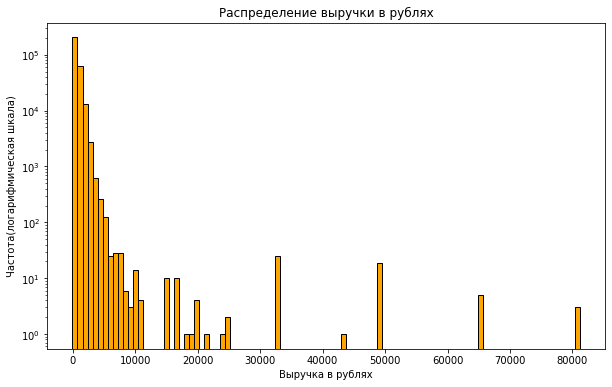

In [25]:
# Построим гистограмму
plt.figure(figsize=(10, 6))
plt.hist(df_rub['revenue'], bins=100, color='orange', edgecolor='black', log=True)
plt.xlabel('Выручка в рублях')
plt.ylabel('Частота(логарифмическая шкала)')
plt.title('Распределение выручки в рублях')
plt.show()

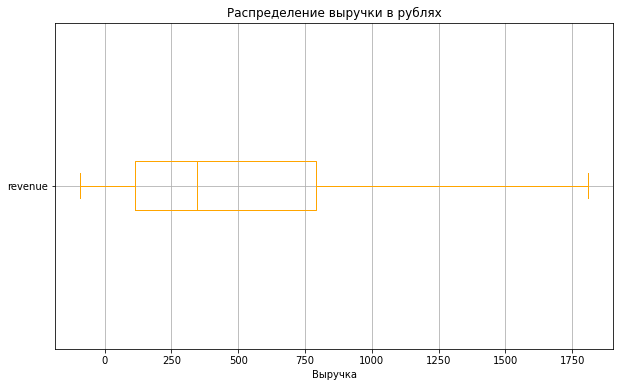

In [26]:
# Построим боксплот
plt.figure(figsize=(10,6))
df_rub.boxplot(column='revenue', color='orange',vert=False, showfliers = False)
plt.title('Распределение выручки в рублях')
plt.xlabel('Выручка')
plt.show()

Разброс значений вокруг среднего очень большой: стандартное отклонение превышает среднее. Медиана существенно ниже среднего (547,59 руб.), что указывает на правый скос распределения: есть редкие, но очень крупные значения, тянущие среднее вверх. Есть отрицательные значения (возврат средств или ошибка). Максимальное значение сильно превышает медиану — явный выброс или аномалия. На гистограмме заметно правосторонняя ассиметрия. Выбросы — по точкам за усами на боксплоте наблюдаются в большую сторону.

In [27]:
#Выводим статистические показатели по столбцу revenue в тенге
df_kzt['revenue'].describe()

count     5069.000000
mean      4995.206767
std       4916.752776
min          0.000000
25%        518.100000
50%       3698.830000
75%       7397.660000
max      26425.860000
Name: revenue, dtype: float64

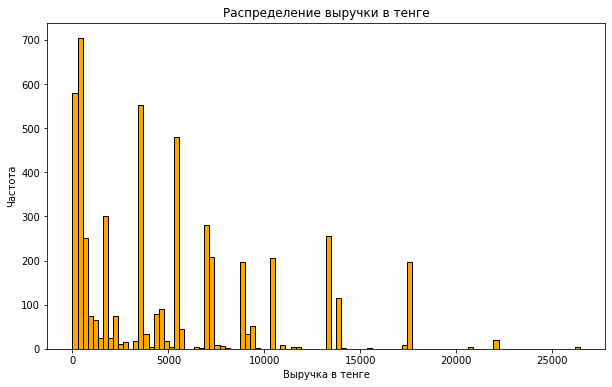

In [28]:
# Построим гистограмму
plt.figure(figsize=(10,6))
plt.hist(df_kzt['revenue'],bins=100,color='orange', edgecolor='black')
plt.xlabel('Выручка в тенге')
plt.ylabel('Частота')
plt.title('Распределение выручки в тенге')
plt.show()

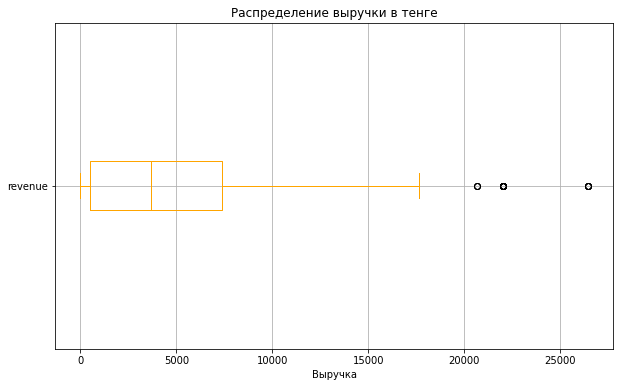

In [29]:
# Построим боксплот
plt.figure(figsize=(10,6))
df_kzt.boxplot(column ='revenue',color='orange',vert=False)
plt.title('Распределение выручки в тенге')
plt.xlabel('Выручка')
plt.show()

Разброс значений вокруг среднего очень велик, почти равен среднему. Это признак сильной неоднородности данных. Есть нулевые значения (отменённые заказы, ошибки). Медиана существенно ниже среднего (4 995,21 тенге), редкие крупные значения тянут среднее вверх. Максимальное значение сильно превышает среднее — явный выброс. Распределение имеет правостороннюю ассиметрию. Выбросы на боксплоте все в большую сторону.

In [30]:
#Выводим статистические показатели по столбцу tickets_count
clean['tickets_count'].describe()

count    290819.000000
mean          2.754256
std           1.170461
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          57.000000
Name: tickets_count, dtype: float64

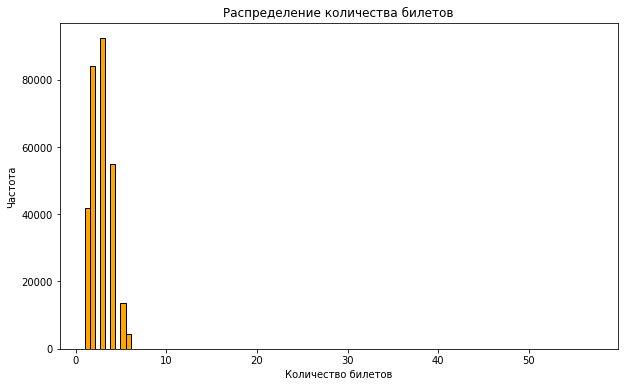

In [31]:
# Построим гистограмму
plt.figure(figsize=(10,6))
plt.hist(clean['tickets_count'],bins=100,color='orange', edgecolor='black')
plt.xlabel('Количество билетов')
plt.ylabel('Частота')
plt.title('Распределение количества билетов')
plt.show()

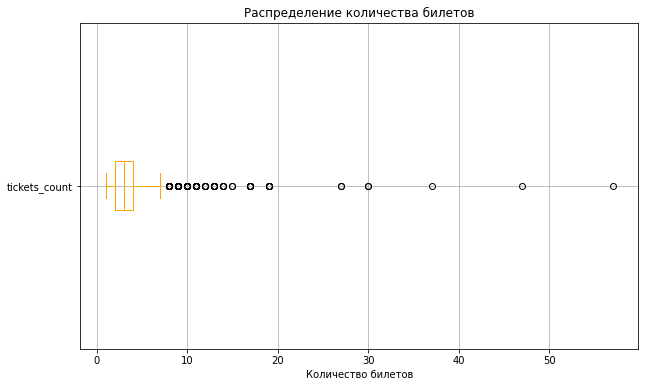

In [32]:
# Построим боксплот
plt.figure(figsize=(10,6))
clean.boxplot(column ='tickets_count',color='orange',vert=False)
plt.title('Распределение количества билетов')
plt.xlabel('Количество билетов')
plt.show()

В среднем покупают 3 билета. Медиана близка к среднему (2,75), что говорит об умеренной симметричности распределения. Есть большое количество билетов, максимум-57. Это либо ошибка, либо покупка на большую группу людей (корпоративная).

In [33]:
# Определим 99-е процентили выручки для обеих валют
proc_rub_99 = df_rub['revenue'].quantile(0.99)
proc_kzt_99 = df_kzt['revenue'].quantile(0.99)

In [34]:
# Отфильтруем датафреймы по 99-му процентилю
df_rub_99 = df_rub[df_rub['revenue']<=proc_rub_99]
df_kzt_99 = df_kzt[df_kzt['revenue']<=proc_kzt_99]

In [35]:
# Объединим датафреймы
new_df = pd.concat([df_rub_99,df_kzt_99])

### Преобразование типов данных

In [36]:
# Меняем тип данных для created_dt_msk
new_df['created_dt_msk'] = pd.to_datetime(new_df['created_dt_msk'])

In [37]:
# Меняем тип данных для created_ts_msk
new_df['created_ts_msk'] = pd.to_datetime(new_df['created_ts_msk'])

In [38]:
# Меняем тип данных для data
tenge_df['data'] = pd.to_datetime(tenge_df['data'])

In [39]:
# Понижаем разрядность целочисленных значений new_df
for column in ['order_id','event_id','city_id','venue_id','age_limit','tickets_count','days_since_prev']:
    new_df[column] = pd.to_numeric(new_df[column], downcast='integer')

In [40]:
# Понижаем разрядность вещественных значений new_df
for column in ['revenue','total']:
    new_df[column] = pd.to_numeric(new_df[column], downcast='float')

In [41]:
# Понижаем разрядность целочисленных значений tenge_df
tenge_df['nominal'] = pd.to_numeric(tenge_df['nominal'],downcast='integer')

In [42]:
# Понижаем разрядность вещественных значений tenge_df
tenge_df['curs'] = pd.to_numeric(tenge_df['curs'],downcast='float')

### Создаём столбцы

In [43]:
# Объединяем основной датафрейм с информацией о курсе тенге
df_col = new_df.merge(tenge_df[['data','curs']],how='left', left_on= new_df['created_dt_msk'].dt.date,right_on = tenge_df['data'].dt.date)
df_col.head()

,key_0,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,...,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address,data,curs
0,2024-08-20,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,...,театр,№3322,Каменевский регион,Глиногорск,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",2024-08-20,18.697201
1,2024-07-23,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,...,выставки,№4850,Каменевский регион,Глиногорск,213,2941,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4",2024-07-23,18.341900
2,2024-10-06,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,...,другое,№1540,Каменевский регион,Глиногорск,213,4507,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6",2024-10-06,19.647499
3,2024-07-13,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,...,другое,№5049,Североярская область,Озёрск,2,3574,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8",2024-07-13,18.500999
4,2024-10-04,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,...,стендап,№832,Озернинский край,Родниковецк,240,1896,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8",2024-10-04,19.664801


In [44]:
# Создадим столбец revenue_rub
def revenue_rub(row):
    if row['currency_code'] == 'kzt':
        return row['revenue'] * row['curs'] / 100
    else:
        return row['revenue']
df_col['revenue_rub'] = df_col.apply(revenue_rub, axis=1)

In [45]:
# Создадим столбец one_ticket_revenue_rub
df_col['one_ticket_revenue_rub'] = df_col['revenue_rub']/df_col['tickets_count']

In [46]:
# Создадим столбец month
df_col['month'] = df_col['created_dt_msk'].dt.month

In [47]:
# Создадим столбец season
def season(month):
    if month in [12,1,2]:
        return 'Зима'
    elif month in [3,4,5]:
        return 'Весна'
    elif month in [6,7,8]:
        return 'Лето'
    else:
        return 'Осень'
df_col['season'] = df_col['month'].apply(season)

In [48]:
# выведем информацию о датафрейме
df_col.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287932 entries, 0 to 287931
Data columns (total 31 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   key_0                   287932 non-null  object        
 1   order_id                287932 non-null  int32         
 2   user_id                 287932 non-null  object        
 3   created_dt_msk          287932 non-null  datetime64[ns]
 4   created_ts_msk          287932 non-null  datetime64[ns]
 5   event_id                287932 non-null  int32         
 6   cinema_circuit          287932 non-null  object        
 7   age_limit               287932 non-null  int8          
 8   currency_code           287932 non-null  object        
 9   device_type_canonical   287932 non-null  object        
 10  revenue                 287932 non-null  float32       
 11  service_name            287932 non-null  object        
 12  tickets_count           287932

В данном разделе загрузили данные, ознакомились с ними. Объединили датафрейм, проверили на пропуски, заменили их на значения-индикаторы. Найдены 30 дубликатов и удалены. Изучены категориальные и количественные столбцы. Преобразованы столбцы к необходимому типу данных и снизили разрядность числовых столбцов. созданы новые столбцы revenue_rub, one_ticket_revenue_rub, month и season. Датафрейм готов к дальнейшей работе.

## Исследовательский анализ данных

###  Анализ распределения заказов по сегментам и их сезонные изменения

In [49]:
# Исследуем количество заказов по месяцам
counts_month = df_col['month'].value_counts().sort_index().reset_index().rename(columns={'index': 'Месяц', 'month': 'Количество'})
counts_month.style.hide_index()

Месяц,Количество
6,34343
7,40410
8,44572
9,69333
10,99274


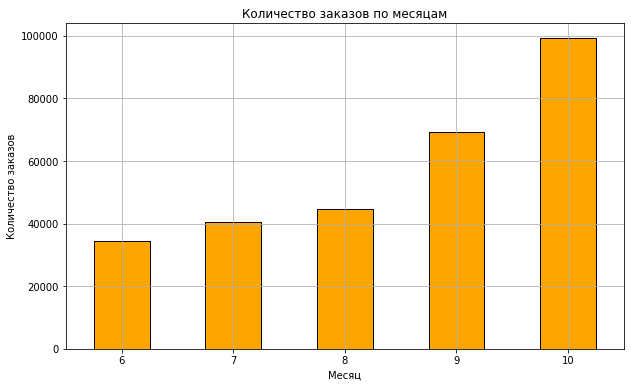

In [50]:
# Построим график
df_col['month'].value_counts().sort_index().plot(kind='bar',figsize=(10,6),legend=False,color='orange',edgecolor='black',rot=0,
                  title='Количество заказов по месяцам',ylabel='Количество заказов',xlabel='Месяц')
plt.grid()
plt.show()

Заметен устойчивый рост заказов к осени. С июня до октября количество заказов выросло больше, чем в 2 раза.

In [51]:
# Расчитаем количество заказов по мероприятиям
df_col['event_type_main'].value_counts().reset_index().rename(columns={'index':'Мероприятие','event_type_main':'Количество'})

,Мероприятие,Количество
0,концерты,113451
1,театр,66677
2,другое,65594
3,спорт,21887
4,стендап,13269
5,выставки,4852
6,ёлки,1964
7,unknow,238


In [52]:
# Создадим летнюю и осеннюю маску
summer_mask = df_col['season']=='Лето'
fall_mask = df_col['season']=='Осень'

In [53]:
# Расчитаем долю летних заказов по мероприятиям
summer = df_col[summer_mask & (df_col['event_type_main']!='unknow')]['event_type_main'].value_counts(normalize=True).round(4)*100
summer.map("{:.2f}%".format)

концерты    42.61%
другое      27.18%
театр       20.10%
стендап      5.33%
спорт        2.52%
выставки     2.03%
ёлки         0.23%
Name: event_type_main, dtype: object

In [54]:
# Расчитаем долю осенних заказов по мероприятиям
fall = df_col[fall_mask & (df_col['event_type_main']!='unknow')]['event_type_main'].value_counts(normalize=True).round(4)*100
fall.map("{:.2f}%".format)

концерты    37.19%
театр       25.35%
другое      19.71%
спорт       11.20%
стендап      4.11%
выставки     1.44%
ёлки         1.00%
Name: event_type_main, dtype: object

In [55]:
# Объединим в датафрейм для демонстрации
s_f_display = pd.DataFrame({'Лето':summer.map("{:.2f}%".format),'Осень':fall.map("{:.2f}%".format)})
s_f_display

,Лето,Осень
выставки,2.03%,1.44%
другое,27.18%,19.71%
концерты,42.61%,37.19%
спорт,2.52%,11.20%
стендап,5.33%,4.11%
театр,20.10%,25.35%
ёлки,0.23%,1.00%


In [56]:
# Объединим в датафрейм для графика
s_f = pd.DataFrame({'Лето':summer,'Осень':fall})

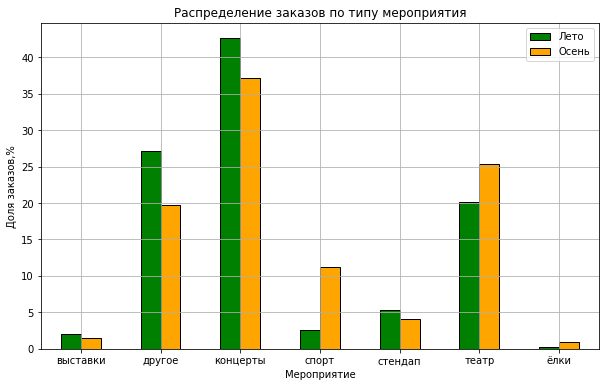

In [57]:
# Построим график
s_f.plot(kind='bar',figsize=(10,6),legend=True,grid=True,color=['green','orange'],edgecolor='black',rot=0,
                  title='Распределение заказов по типу мероприятия',ylabel='Доля заказов,%',xlabel='Мероприятие')
plt.show()

Летом и осенью самые распространённые мероприятия: концерты,театры, категория другое. Однако, осенью заметен рост доли спортивных мероприятий, но рост незначительный в абсолютных значениях.

In [58]:
# Расчитаем количество заказов по устройствам
df_col['device_type_canonical'].value_counts().reset_index().rename(columns={'index':'Устройство','device_type_canonical':'Количество'})

,Устройство,Количество
0,mobile,230526
1,desktop,57406


In [59]:
# Расчитаем долю летних заказов по типу устройства
summer_type = df_col[summer_mask]['device_type_canonical'].value_counts(normalize=True).round(4)*100
summer_type.map("{:.2f}%".format)

mobile     80.64%
desktop    19.36%
Name: device_type_canonical, dtype: object

In [60]:
# Расчитаем долю осенних заказов по типу устройства
fall_type = df_col[fall_mask]['device_type_canonical'].value_counts(normalize=True).round(4)*100
fall_type.map("{:.2f}%".format)

mobile     79.66%
desktop    20.34%
Name: device_type_canonical, dtype: object

In [61]:
# Объединим в датафрейм для демонстрации
t_d_display = pd.DataFrame({'Лето':summer_type.map("{:.2f}%".format),'Осень':fall_type.map("{:.2f}%".format)})
t_d_display

,Лето,Осень
mobile,80.64%,79.66%
desktop,19.36%,20.34%


In [62]:
# Объединим в датафрейм для графика
t_d = pd.DataFrame({'Лето':summer_type,'Осень':fall_type})
t_d

,Лето,Осень
mobile,80.64,79.66
desktop,19.36,20.34


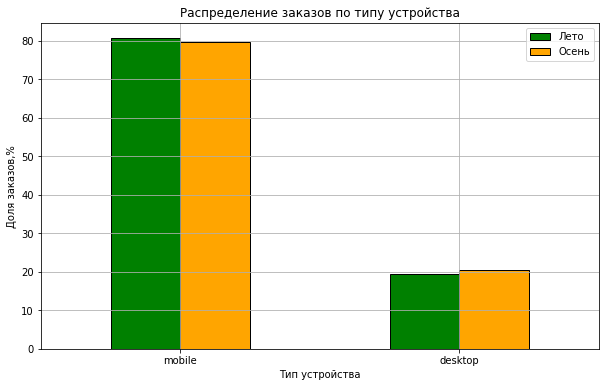

In [63]:
# Построим график
t_d.plot(kind='bar',figsize=(10,6),legend=True,grid=True,color=['green','orange'],edgecolor='black',rot=0,
                  title='Распределение заказов по типу устройства',ylabel='Доля заказов,%',xlabel='Тип устройства')
plt.show()

Сезон никак не влияет на тип устройства. Разница  меньше двух процентных пунктов. Пользователи отдают предпочтение мобильным устройствам.

In [64]:
# Исследуем динамику по возрастному рейтингу
df_col['age_limit'].value_counts().reset_index().rename(columns={'index':'Рейтинг','age_limit':'Количество'})

,Рейтинг,Количество
0,16,77996
1,12,61753
2,0,61232
3,6,51404
4,18,35547


In [65]:
# Расчитаем долю летних заказов по рейтингу
summer_rating = df_col[summer_mask]['age_limit'].value_counts(normalize=True).round(4)*100
summer_rating.map("{:.2f}%".format)

16    28.31%
12    20.55%
6     18.17%
0     17.94%
18    15.04%
Name: age_limit, dtype: object

In [66]:
# Расчитаем долю осенних заказов по рейтингу
fall_rating = df_col[fall_mask]['age_limit'].value_counts(normalize=True).round(4)*100
fall_rating.map("{:.2f}%".format)

16    26.23%
0     23.62%
12    22.08%
6     17.63%
18    10.44%
Name: age_limit, dtype: object

In [67]:
# Объединим в датафрейм для демонстрации
t_r_display = pd.DataFrame({'Лето':summer_rating.map("{:.2f}%".format),'Осень':fall_rating.map("{:.2f}%".format)})
t_r_display

,Лето,Осень
0,17.94%,23.62%
6,18.17%,17.63%
12,20.55%,22.08%
16,28.31%,26.23%
18,15.04%,10.44%


In [68]:
# Объединим в датафрейм для графика
t_r = pd.DataFrame({'Лето':summer_rating,'Осень':fall_rating})

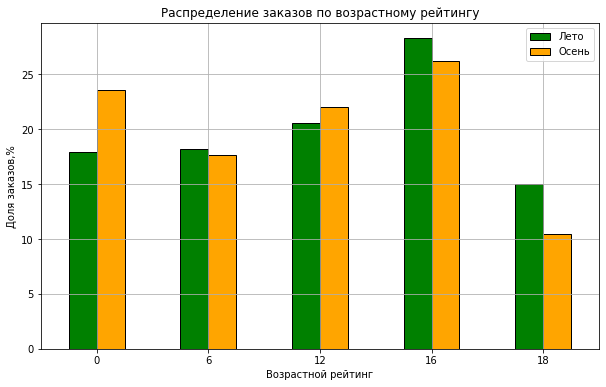

In [69]:
# Построим график
t_r.plot(kind='bar',figsize=(10,6),legend=True,grid=True,color=['green','orange'],edgecolor='black',rot=0,
                  title='Распределение заказов по возрастному рейтингу',ylabel='Доля заказов,%',xlabel='Возрастной рейтинг')
plt.show()

Категория 0+ увеличивает долю осенью на 5 п.п, вероятно это связано с началом учебного года в школах, категория 6+ почти неизменна, также как и 12+ - небольшой рост осенью на 3 п.п. В старших категориях (16+ и 18+) явный рост летом, более заметный у категории 18% (почти 5 п.п) - вероятно связано с отпусками и завершением учебного года в ВУЗах.

In [70]:
# Исследуем среднюю выручку с одного билета летом и осенью
avg_revenue = df_col[df_col['event_type_main']!='unknow'].groupby(['event_type_main','season'])['one_ticket_revenue_rub'].mean().round(4).unstack(fill_value=0)
avg_revenue

season,Лето,Осень
event_type_main,,
выставки,86.4162,90.6036
другое,77.4340,76.1153
концерты,304.7171,268.0841
спорт,50.7618,49.9697
стендап,218.5181,231.1250
театр,214.1263,175.9695
ёлки,271.4362,229.5856


In [71]:
# Выведем относительное изменение выручки с лета по осень
change = (avg_revenue['Осень'] / avg_revenue['Лето'] - 1) * 100
change.map("{:.2f}%".format)

event_type_main
выставки      4.85%
другое       -1.70%
концерты    -12.02%
спорт        -1.56%
стендап       5.77%
театр       -17.82%
ёлки        -15.42%
dtype: object

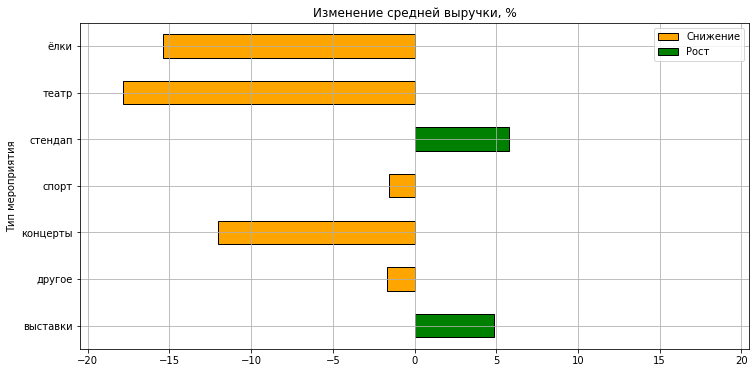

In [72]:
# Построим график
fig, ax = plt.subplots(figsize=(12, 6))
colors = ['orange' if x < 0 else 'green' for x in change]
change.plot(kind='barh',grid=True,color=colors,edgecolor='black',
                  title='Изменение средней выручки, %',ylabel='Относительное изменение, %',xlabel='Тип мероприятия')
legend_elements = [Patch(facecolor='orange', edgecolor='black', label='Снижение'),
                   Patch(facecolor='green', edgecolor='black', label='Рост')]
ax.legend(handles=legend_elements, loc='upper right')
x_max = max(abs(change.values)) * 1.15
ax.set_xlim(-x_max, x_max)
plt.show()

Отмечаем падение выручки с билета в 5 категориях осенью (театр - 17,82%, елки - 15,42%, концерты - 12.02%, другое -1.70% и спорт -1.56%), 2 категории растут - стендап и выставки. Самые высокие выручки с билета в категориях - концерты, ёлки, стендап и театр - большее 200 рублей за билет в среднем.

### Осенняя активность пользователей

In [73]:
# Исследуем динамику количества заказов и пользователей по дням
summary = df_col[fall_mask].groupby('created_dt_msk').agg(total_orders=('order_id', 'count'),
                                               unique_users=('user_id', 'nunique'),
                                               avg_ticket_price=('one_ticket_revenue_rub', 'mean')).reset_index()

In [74]:
# Добавляем столбец «заказов на пользователя»
summary['orders_per_user'] = (summary['total_orders'] / summary['unique_users']).round(4)
summary

,created_dt_msk,total_orders,unique_users,avg_ticket_price,orders_per_user
0,2024-09-01,1327,564,200.168708,2.3528
1,2024-09-02,1380,574,189.464640,2.4042
2,2024-09-03,5111,778,80.130097,6.5694
3,2024-09-04,1773,685,177.685576,2.5883
4,2024-09-05,1944,739,189.510156,2.6306
...,...,...,...,...,...
56,2024-10-27,2849,1034,186.968329,2.7553
57,2024-10-28,2838,985,170.654940,2.8812
58,2024-10-29,2836,998,177.409612,2.8417
59,2024-10-30,2928,1040,182.729054,2.8154


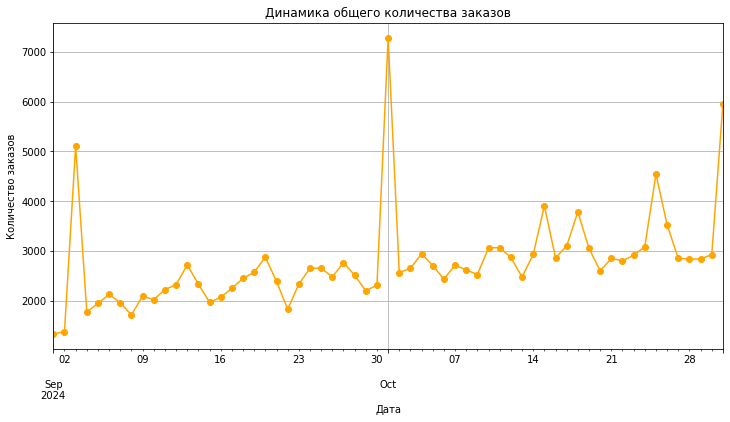

In [75]:
# Построим график
summary.plot(x='created_dt_msk', y='total_orders', kind='line', figsize=(12, 6),marker='o',color='orange',legend=False)
plt.title('Динамика общего количества заказов')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.grid()
plt.show()

По графику виден тренд на рост числа заказов осенью с несколькими большими пиками в начале и конце сентрября, а также в концк октября. Возможно в это время были акционные предложения.

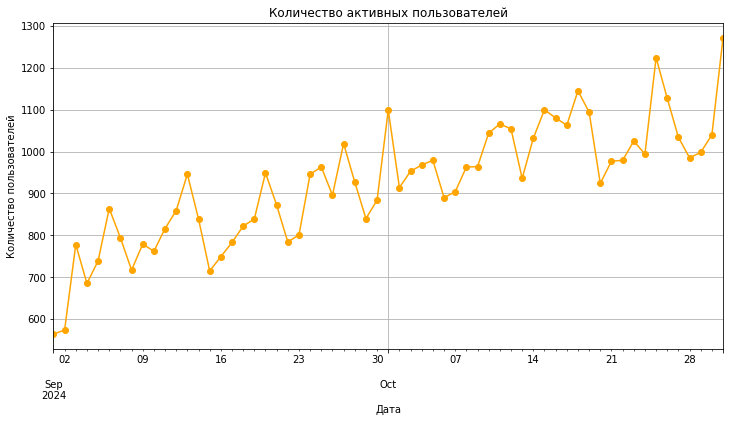

In [76]:
# Построим график
summary.plot(x='created_dt_msk', y='unique_users', kind='line', figsize=(12, 6),marker='o',color='orange',legend=False)
plt.title('Количество активных пользователей')
plt.ylabel('Количество пользователей')
plt.xlabel('Дата')
plt.grid()
plt.show()

Наблюдается стабильный рост количества активных пользователей,нет очевидных резких пиков или спадов.

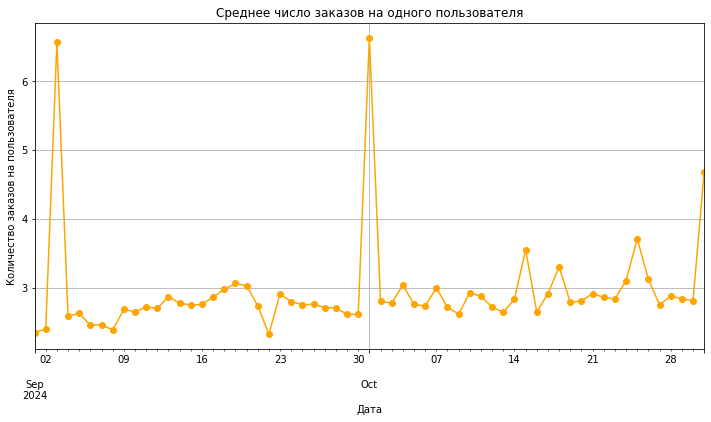

In [77]:
# Построим график
summary.plot(x='created_dt_msk', y='orders_per_user', kind='line', figsize=(12, 6),marker='o',color='orange',legend=False)
plt.title('Среднее число заказов на одного пользователя')
plt.ylabel('Количество заказов на пользователя')
plt.xlabel('Дата')
plt.grid()
plt.show()

 Среднее количество билетов в заказе составляет почти 3 билета. Некоторые пики имеют высокое значения в те же даты, что и у общего числа заказов.

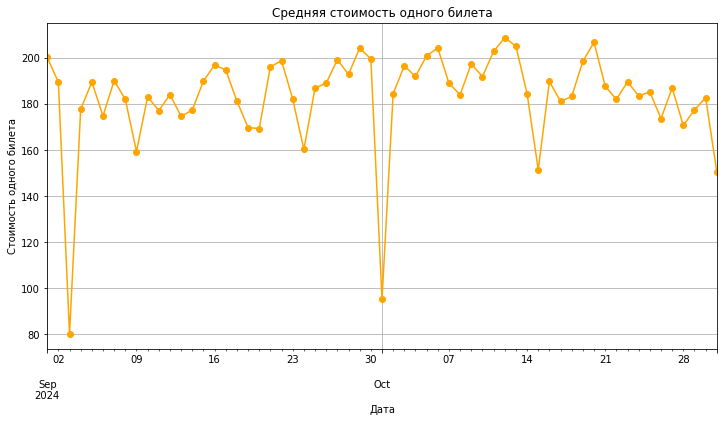

In [78]:
# Построим график
summary.plot(x='created_dt_msk', y='avg_ticket_price', kind='line', figsize=(12, 6),marker='o',color='orange',legend=False)
plt.title('Средняя стоимость одного билета')
plt.ylabel('Стоимость одного билета')
plt.xlabel('Дата')
plt.grid()
plt.show()

Можно отметить, что резкие увеличение количество заказов приходится как раз на резкое снижение стоимости билетов. Скорее всего вводились скидки, что стимулировало продажу билетов. Часть совпадений есть, но это не устойчивая закономерность. С середины октября наблюдаем небольшой спад до конца осени. 

In [79]:
# Извлекаем день недели из даты 
df_col['day_of_week'] = df_col['created_dt_msk'].dt.dayofweek  

In [80]:
# Создадим переменную для переименовывания дней недели
day_map = {
    'Monday': 'Понедельник',
    'Tuesday': 'Вторник', 
    'Wednesday': 'Среда',
    'Thursday': 'Четверг',
    'Friday': 'Пятница',
    'Saturday': 'Суббота',
    'Sunday': 'Воскресенье'}

In [81]:
# Возвращаем названия дней недели
df_col['day_name'] = df_col['created_dt_msk'].dt.day_name().map(day_map)

In [82]:
# Исследуем динамику количества заказов и пользователей по дням
summarys = df_col[fall_mask].groupby('day_name').agg(total_orders=('order_id', 'count'),
                                               unique_users=('user_id', 'nunique'),
                                               avg_ticket_price=('one_ticket_revenue_rub', 'mean'),
                                               total_revenue=('revenue_rub', 'sum')).reset_index()

In [83]:
# Приводим выручку к читаемой форме
summarys['total_revenue'] = summarys['total_revenue'].round(2)

In [84]:
# Добавляем столбец «заказов на пользователя»
summarys['orders_per_user'] = (summarys['total_orders'] / summarys['unique_users']).round(4)

In [85]:
# Создадим переменную для упорядычивания дней недели
days_order = [ 'Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']

In [86]:
# Преобразуем столбец в категориальный с заданным порядком
summarys['day_name'] = pd.Categorical(summarys['day_name'],categories=days_order,ordered=True)

In [87]:
# Создадим таблицу для визуализации
for_visual = summarys.sort_values('day_name').reset_index(drop=True)
for_visual

,day_name,total_orders,unique_users,avg_ticket_price,total_revenue,orders_per_user
0,Понедельник,21517,4448,184.081657,10749789.12,4.8375
1,Вторник,31480,4793,140.496802,12155526.31,6.5679
2,Среда,22888,4813,185.685146,11506924.79,4.7555
3,Четверг,27169,4970,177.888277,13006652.00,5.4666
4,Пятница,24828,4870,185.542069,12597553.37,5.0982
5,Суббота,21336,4571,192.079949,11272098.38,4.6677
6,Воскресенье,19389,4394,197.921015,10485404.04,4.4126


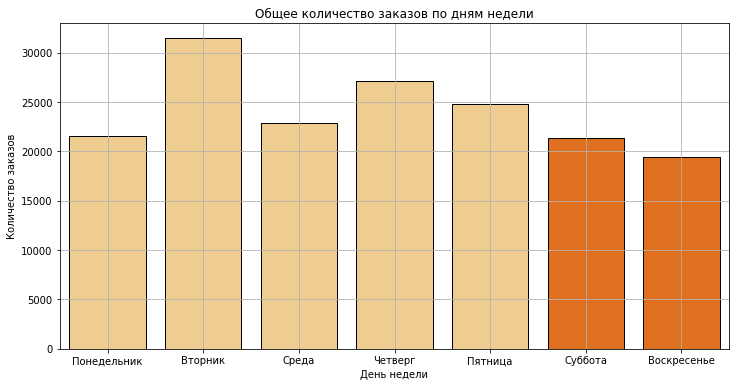

In [88]:
# Построим график
plt.figure(figsize=(12, 6))
colors = []
for day in for_visual['day_name']:
    if day in ['Суббота', 'Воскресенье']:
        colors.append('#FF6B00')
    else:
        colors.append('#FFD080')
sns.barplot(
    data=for_visual,
    x='day_name',
    y='total_orders',
    palette=colors,
    edgecolor='black')
plt.title('Общее количество заказов по дням недели')
plt.xlabel('День недели')
plt.ylabel('Количество заказов')
plt.grid()
plt.show()

Пиковая активность по оформлению заказов наблюдается во вторник (31 480 заказов), четверг (27 169) и пятницу (24 828). Минимальная — в воскресенье (19 389), субботу (21 336) и понедельник (21 517).

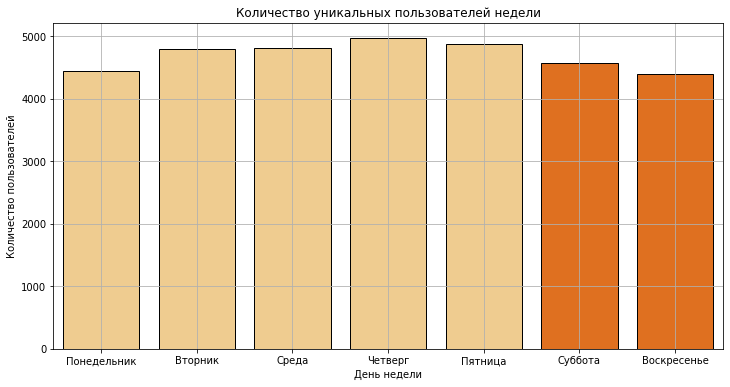

In [89]:
# Построим график
plt.figure(figsize=(12, 6))
sns.barplot(
    data=for_visual,
    x='day_name',
    y='unique_users',
    palette=colors,
    edgecolor='black')
plt.title('Количество уникальных пользователей недели')
plt.xlabel('День недели')
plt.ylabel('Количество пользователей')
plt.grid()
plt.show()

Уникальных пользователей во все дни более 4300. Больше всего пользователей появляется со вторника по пятницу. Существенных перепадов нет - особенно по сравнению с динамикой заказов

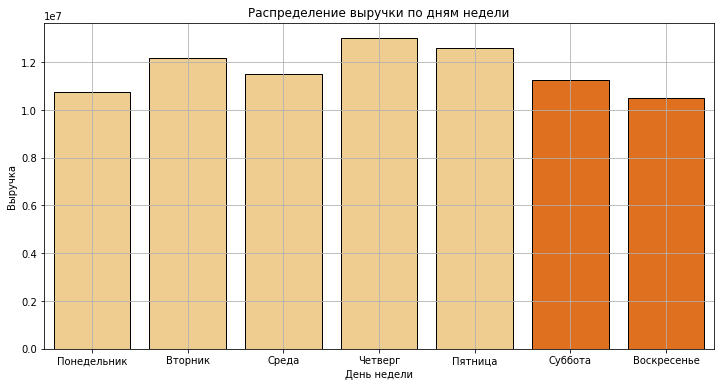

In [90]:
# Построим график
plt.figure(figsize=(12, 6))
sns.barplot(
    data=for_visual,
    x='day_name',
    y='total_revenue',
    palette=colors,
    edgecolor='black')
plt.title('Распределение выручки по дням недели')
plt.xlabel('День недели')
plt.ylabel('Выручка')
plt.grid()
plt.show()

Выручка как и количество заказов выше в четверг,пятницу и вторник. Разница невелика, сильных перекосов нет.

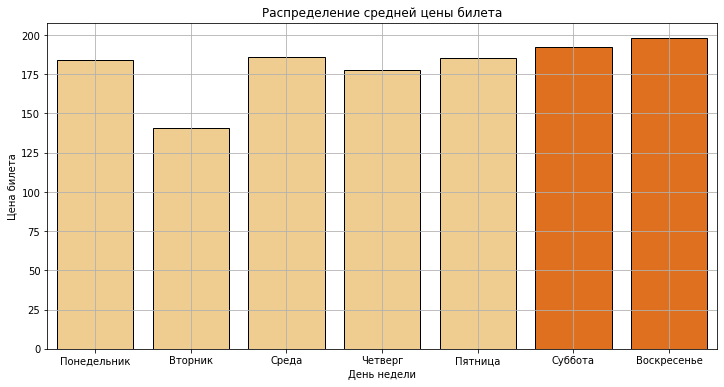

In [91]:
# Построим график
plt.figure(figsize=(12, 6))
sns.barplot(
    data=for_visual,
    x='day_name',
    y='avg_ticket_price',
    palette=colors,
    edgecolor='black')
plt.title('Распределение средней цены билета')
plt.xlabel('День недели')
plt.ylabel('Цена билета')
plt.grid()
plt.show()

Самые низкие цены на билеты во вторник. Т.к. выручки в эти дни высокие и количество заказов тоже большое - возможно,по вторникам чаще всего вводят различные акции и скидки. Однако, в остальные дни разница по ценам небольшая. 

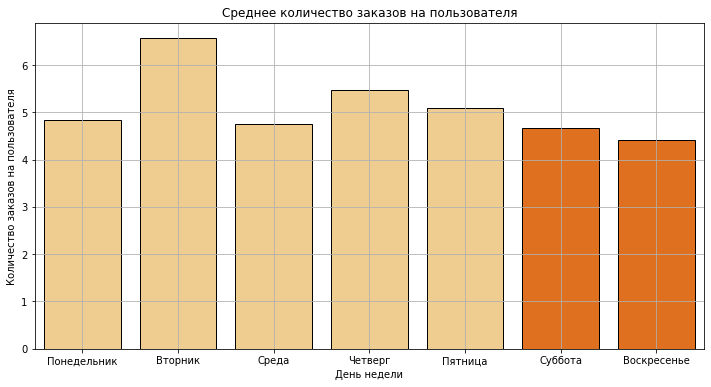

In [92]:
# Построим график
plt.figure(figsize=(12, 6))
sns.barplot(
    data=for_visual,
    x='day_name',
    y='orders_per_user',
    palette=colors,
    edgecolor='black')
plt.title('Среднее количество заказов на пользователя')
plt.xlabel('День недели')
plt.ylabel('Количество заказов на пользователя')
plt.grid()
plt.show()

В среднем на пользователя приходится 4 билета. В будние дни отличаются сильнее, чем выходные. Среднее завышается за счёт отдельных пиков, а типичные значения ниже. Снова выбивается вторник. Причины те же: раз меньше цена, то можно купить большне билетов,например, на корпоратив, класс, большую компанию.

In [93]:
# Среднее количество заказов за выходные
mean_weekend = for_visual[for_visual['day_name'].isin(['Суббота','Воскресенье'])]['total_orders'].mean()

In [94]:
# Среднее количество заказов за будние
mean_weekdays = for_visual[~for_visual['day_name'].isin(['Суббота','Воскресенье'])]['total_orders'].mean()

In [95]:
# Объединим в датафрейм для графика
w_w = pd.DataFrame({'Будни':mean_weekdays,'Выходные':mean_weekend}, index=['Среднее'])
w_w

,Будни,Выходные
Среднее,25576.4,20362.5


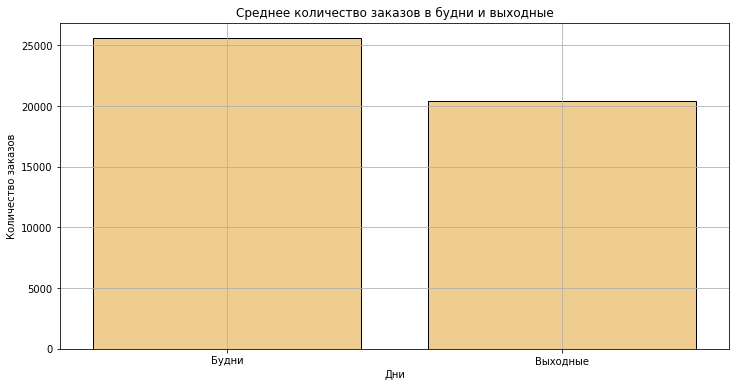

In [96]:
# Построим график
plt.figure(figsize=(12, 6))
sns.barplot(
    data=w_w,
    palette=colors,
    edgecolor='black')
plt.title('Среднее количество заказов в будни и выходные')
plt.xlabel('Дни')
plt.ylabel('Количество заказов')
plt.grid()
plt.show()

Среднее количество заказов в выходные меньше, чем в будни (разница более 5000 заказов). 

### Популярные события и партнёры

In [97]:
# Посчитаем общее количество мероприятий и заказов
total_events = df_col[fall_mask]['event_id'].nunique()
total_orders = df_col[fall_mask]['order_id'].count()

In [98]:
# Посчитаем необходимые метрики
reg = df_col[fall_mask].groupby('region_name').agg(count_orders=('order_id','count'),
                                                     count_events=('event_id','nunique'))
reg['events_part'] = (reg['count_events'] / total_events * 100).round(2)
reg['users_part'] = (reg['count_orders'] / total_orders * 100).round(2)

In [99]:
# Выведем топ-10 регионов по мероприятиям
reg_10 = reg.sort_values('count_events', ascending=False).head(10).reset_index()
reg_10

,region_name,count_orders,count_events,events_part,users_part
0,Каменевский регион,46684,3910,24.62,27.69
1,Североярская область,20718,2613,16.45,12.29
2,Широковская область,8715,803,5.06,5.17
3,Светополянский округ,4779,764,4.81,2.83
4,Речиновская область,3565,529,3.33,2.11
5,Серебринская область,4467,456,2.87,2.65
6,Яблоневская область,4199,432,2.72,2.49
7,Тепляковская область,2485,419,2.64,1.47
8,Горицветская область,3230,406,2.56,1.92
9,Солнечноземская область,4228,403,2.54,2.51


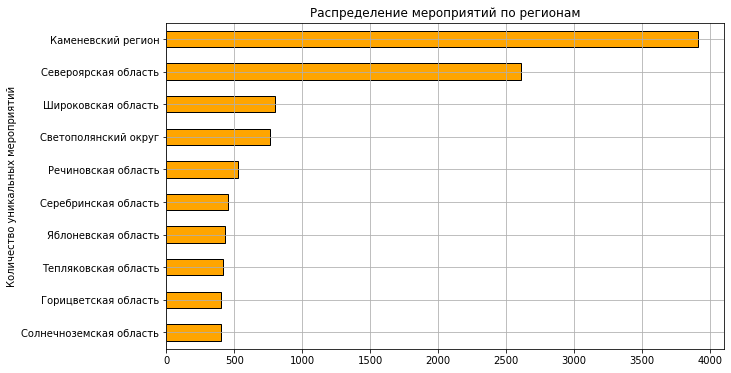

In [100]:
# Построим график
reg_10_flipped = reg_10.iloc[::-1]
reg_10_flipped.plot(kind='barh', x='region_name',y='count_events',figsize=(10,6),
            grid=True,color='orange',edgecolor='black',rot=0,legend=False,
            title='Распределение мероприятий по регионам',ylabel='Регион',xlabel='Количество уникальных мероприятий')
plt.show()

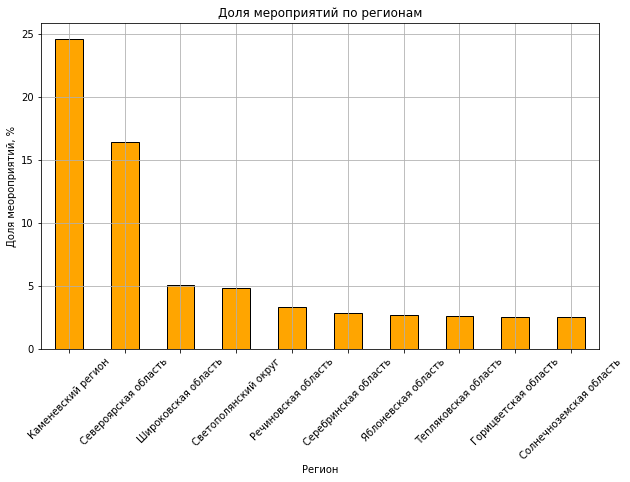

In [101]:
# Построим график
reg_10.plot(kind='bar', x='region_name',y='events_part',figsize=(10,6),
            grid=True,color='orange',edgecolor='black',rot=45,legend=False,
            title='Доля мероприятий по регионам',ylabel='Доля меороприятий, %',xlabel='Регион')
plt.show()

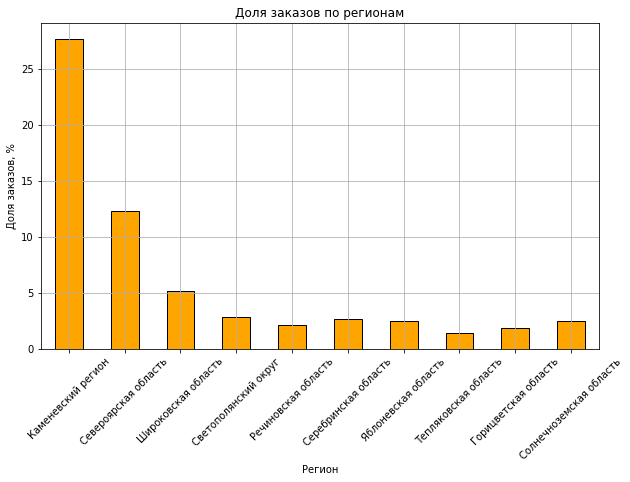

In [102]:
# Построим график
reg_10.plot(kind='bar', x='region_name',y='users_part',figsize=(10,6),
            grid=True,color='orange',edgecolor='black',rot=45,legend=False,
            title='Доля заказов по регионам',ylabel='Доля заказов, %',xlabel='Регион')
plt.show()

По долям заказов и мероприятий лидируют 2 региона: Каменевский регион и Североярская область,но доля Североярской области более умеренная. Остальные имеют показатели значительно ниже (колебания от 5% и менее). Такие значительные различия могут зависить от уровня развитости инфраструктуры регионов. 

In [103]:
# Посчитаем необходимые метрики
service = df_col[fall_mask].groupby('service_name').agg(count_orders=('order_id','count'),
                                                        count_events=('event_id','nunique'),
                                                        total_revenue=('revenue_rub', 'sum'))
service['events_part'] = (service['count_events'] / total_events * 100).round(2)
service['users_part'] = (service['count_orders'] / total_orders * 100).round(2)

In [104]:
# Приводим выручку к читаемой форме
service['total_revenue'] = service['total_revenue'].round(2)

In [105]:
# Выведем топ-10 партнёров по мероприятиям
service_10 = service.sort_values('count_events', ascending=False).head(10).reset_index()
service_10

,service_name,count_orders,count_events,total_revenue,events_part,users_part
0,Лови билет!,25792,3616,10376793.47,22.77,15.30
1,Билеты без проблем,32383,2847,12116005.14,17.93,19.21
2,Билеты в руки,25734,2471,7613965.51,15.56,15.26
3,Облачко,15478,1409,10611051.68,8.87,9.18
4,Лучшие билеты,12445,1397,1676010.07,8.80,7.38
5,Мой билет,19419,1006,10850808.47,6.34,11.52
6,Тебе билет!,3749,859,2137900.34,5.41,2.22
7,Прачечная,5798,728,2548310.46,4.58,3.44
8,Весь в билетах,9406,599,9325570.69,3.77,5.58
9,Яблоко,3473,537,2763332.31,3.38,2.06


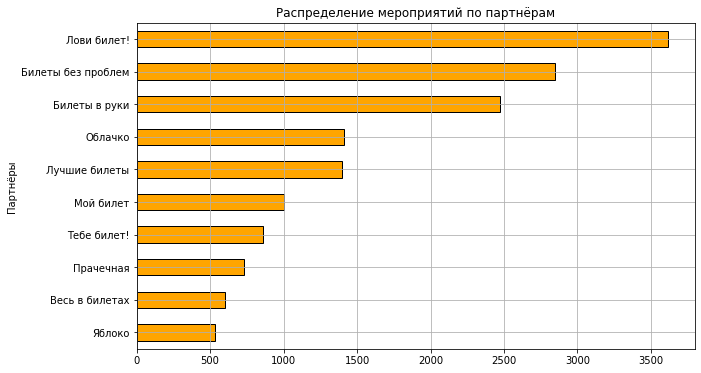

In [106]:
# Построим график
service_10_flipped = service_10.iloc[::-1]
service_10_flipped.plot(kind='barh', x='service_name',y='count_events',figsize=(10,6),
            grid=True,color='orange',edgecolor='black',rot=0,legend=False,
            title='Распределение мероприятий по партнёрам',ylabel='Количество уникальных мероприятий',xlabel='Партнёры')
plt.show()

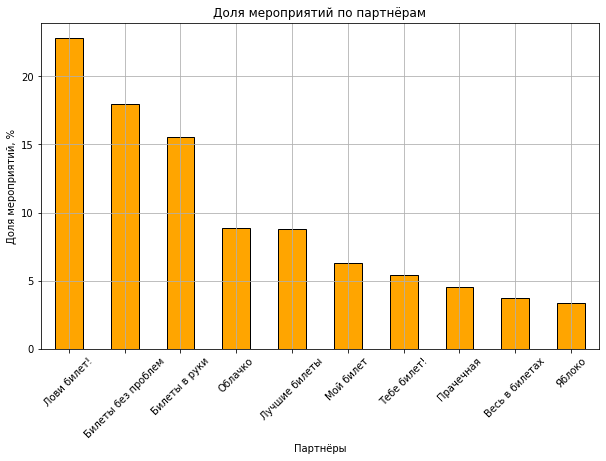

In [107]:
# Построим график
service_10.plot(kind='bar', x='service_name',y='events_part',figsize=(10,6),
            grid=True,color='orange',edgecolor='black',rot=45,legend=False,
            title='Доля мероприятий по партнёрам',ylabel='Доля мероприятий, %',xlabel='Партнёры')
plt.show()

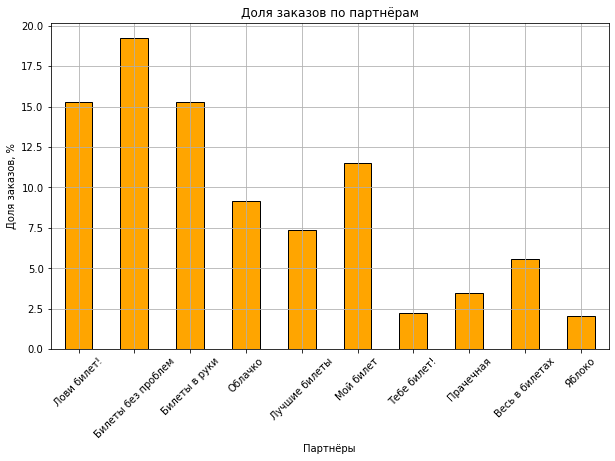

In [108]:
# Построим график
service_10.plot(kind='bar', x='service_name',y='users_part',figsize=(10,6),
            grid=True,color='orange',edgecolor='black',rot=45,legend=False,
            title='Доля заказов по партнёрам',ylabel='Доля заказов, %',xlabel='Партнёры')
plt.show()

Большую часть рынка по мероприятиям и заказам составляют три билетных оператора: "Лови билет!", "Билеты без проблем", "Билеты в руки".

У "Лови билет!" покупают билеты на большее количество мероприятий (3 616) и это составляет 22,72% всего рынка, значительно больше, чем у ближайших конкурентов «Билеты без проблем» (17,93% и 2 847 мероприятий) и «Билеты в руки» (15,56% и 2 471).

Три крупнейших оператора охватывают 56,26 % всех мероприятий.

«Билеты без проблем» — 32 383 заказа (19,21 % от всех пользователей);
«Лови билет!» — 25 792 заказа (15,3 % пользователей);
«Билеты в руки» — 25 734 заказа (15,26 % пользователей).
При этом разрыв между 1‑м и 2‑м местом составляет 6 591 заказ, а между 2‑м и 3‑м — всего 58 заказов. Остальные операторы суммарно занимают 50,23 % рынка.

### Статистический анализ данных

1-я гипотеза звучит так: Среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств.

Нулевая гипотеза H₀: Среднее количество заказов в двух группах (мобильный и ПК) не различается.

Альтернативная гипотеза H₁: Среднее количество заказов в мобильной группе больше, и это различие статистически значимо.

In [109]:
# Сформируем выборки
df_fall = df_col[fall_mask]
mobile_group =df_fall[df_fall['device_type_canonical']=='mobile']['user_id']
desktop_group =df_fall[df_fall['device_type_canonical']=='desktop']['user_id']

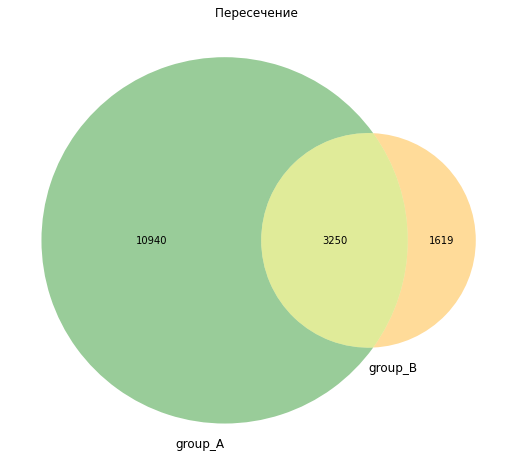

In [110]:
# Найдём пересечение
group_A = set(mobile_group)
group_B = set(desktop_group)
plt.figure(figsize=(16, 8))
venn2([group_A, group_B], set_labels=('group_A', 'group_B'),set_colors=('green', 'orange'))
plt.title("Пересечение ")
plt.show() 

In [111]:
# Находим пользователей в обоих тестах
overlap_users = group_A & group_B

In [112]:
print(f'Размер мобильной выборки: {mobile_group.nunique()}')
print(f'Размер ПК выборки: {desktop_group.nunique()}')
print(f"Пользователей в двух группах одновременно: {len(overlap_users)}")

Размер мобильной выборки: 14190
Размер ПК выборки: 4869
Пользователей в двух группах одновременно: 3250


Найдены пересечения между группами и пользователей мобильного преложения  почти в 3 раза больше, чем пользователей ПК.

In [113]:
# Исключим пересекающихся пользователей
mobile_group_clean = mobile_group[~mobile_group.isin(overlap_users)]
desktop_group_clean = desktop_group[~desktop_group.isin(overlap_users)]

In [114]:
print(f"Исходных записей в мобильной группе: {mobile_group.nunique()} и ПК группе: {desktop_group.nunique()}")
print(f"После удаления пересекающихся в мобильной группе: {mobile_group_clean.nunique()} и ПК группе: {desktop_group_clean.nunique()}")

Исходных записей в мобильной группе: 14190 и ПК группе: 4869
После удаления пересекающихся в мобильной группе: 10940 и ПК группе: 1619


In [115]:
# Сформируем тестовые группы
test_group_a = df_fall[df_fall['user_id'].isin(mobile_group_clean)].groupby('user_id')['order_id'].count()
test_group_b = df_fall[df_fall['user_id'].isin(desktop_group_clean)].groupby('user_id')['order_id'].count()

In [116]:
# Выводим статистику по мобильной группе
test_group_a.describe()

count    10940.000000
mean         2.858501
std          4.096948
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max        123.000000
Name: order_id, dtype: float64

In [117]:
# Выводим статистику по ПК группе
test_group_b.describe()

count    1619.000000
mean        1.974676
std         3.061379
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        56.000000
Name: order_id, dtype: float64

Т.к. среднее заметно выше медианы, то данные имеют правостороннюю ассиметрию. Проводим тест Манна-Уитни (распределение скошенное и есть выбросы).

In [120]:
# Проведём тест Манна-Уитни
stat_test, p_value_mannwhitneyu = mannwhitneyu(test_group_a,test_group_b,alternative='greater')
if p_value_mannwhitneyu > 0.05:
    print(f'{p_value_mannwhitneyu=:.5f}. Нулевая гипотеза не отвергается')
else:
    print(f'{p_value_mannwhitneyu=:.5f}. Принимаем альтернативную гипотезу')

p_value_mannwhitneyu=0.00000. Принимаем альтернативную гипотезу


Достаточно статистических оснований предполагать, что пользователи мобильных устройств покупают больше билетов. 

2-я гипотеза звучит так: Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.

Нулевая гипотеза H₀: Среднее время между заказами пользователей мобильных приложений и пользователями ПК не различается.

Альтернативная гипотеза H₁: Среднее время между заказами пользователей мобильных приложений больше по сравнению с пользователями ПК.

In [121]:
# Сформируем тестовые группы (убираем пропуски и ненулевые значения)
mobile_test2 = df_fall[(df_fall['user_id'].isin(mobile_group_clean)) & (~df_fall['days_since_prev'].isna()) & (df_fall['days_since_prev']>=0)]['days_since_prev']
desktop_test2 = df_fall[(df_fall['user_id'].isin(desktop_group_clean)) &(~df_fall['days_since_prev'].isna()) & (df_fall['days_since_prev']>=0)]['days_since_prev']

In [122]:
# Выводим статистику по мобильной группе
mobile_test2.describe()

count    24591.000000
mean        13.789069
std         25.714392
min          0.000000
25%          0.000000
50%          1.000000
75%         15.000000
max        148.000000
Name: days_since_prev, dtype: float64

In [123]:
# Выводим статистику по ПК группе
desktop_test2.describe()

count    2078.000000
mean       18.061598
std        32.669455
min         0.000000
25%         0.000000
50%         0.000000
75%        22.000000
max       146.000000
Name: days_since_prev, dtype: float64

Здесь также среднее заметно выше медианы, данные имеют правостороннюю ассиметрию. Проводим тест Манна-Уитни (распределение скошенное и есть выбросы). Проведём тест Манна-Уитни.

In [124]:
# Проведём тест Манна-Уитни
stat_test, p_value_mannwhitneyu = mannwhitneyu(
 mobile_test2,
 desktop_test2,
 alternative='greater'
 )
if p_value_mannwhitneyu > 0.05:
    print(f'{p_value_mannwhitneyu=:.5f}. Нулевая гипотеза не отвергается')
else:
    print(f'{p_value_mannwhitneyu=:.5f}. Принимаем альтернативную гипотезу')

p_value_mannwhitneyu=0.00000. Принимаем альтернативную гипотезу


Есть основания предполагать, что среднее время между заказами у пользователей мобильных утсройств выше, чем у пользователей ПК.

### Общий вывод и рекомендации

Проведен исследовательский анализ данных сервиса бронирования билетов Яндекс.Афиша с 1 июня 2024 года по 30 октября 2024 года. Анализ проводился по трём датасетам, которые были предобработаны, объединены, удалены пропуски, дубликаты (30 шт.), выявлены распределения, оптимизированы типы данных, созданы новые нужные для анализа столбцы (revenue_rub — выручка с заказа к единой валюте (российский рубль),one_ticket_revenue_rub — выручка с продажи одного билета на мероприятие, month —
месяц оформления заказа, season — сезон.). В количественном столбце revenue выявлены отрицательные значения, которые могли быть образованы в результате возвратов битетов. По столбцу revenue с выручкой отфильтрованы данные до 99-го перцентиля, исключив выбросы.

В ходе исследования было обнаружено, что осень повышается количество заказов практически в два раза, по сравнению с началом лета. Осенью немного увеличилась доля спортивных событий; летом лидировали концерты и театральные постановки. В разрезе возрастного рейтинга категория 0+ выросла на 5 п.п. (вероятно, из‑за начала учебного года), а категории 16+ и 18+ активнее летом (отпуска, завершение учебного года).Падение средней выручки осенью в категориях: театр - 17,82%, елки - 15,42%, концерты - 12.02%, другое -1.70% и спорт -1.56%. Рост в категориях: стендап (+20 %), выставки (+15 %). Самые дорогие билеты: концерты, ёлки, стендап, театр (свыше 200 руб. за билет). Максимальная активность по оформлению заказов наблюдается во вторник, четверг и пятницу. DAU: стабильно выше 4 300 пользователей в день, пик — со вторника по пятницу. Лидеры по заказам и мероприятиям: лидирует Каменевский регион, занимающий доминирующую долю рынка. Североярская область — второй по значимости регион, но её доля примерно вдвое меньше, чем у Каменевского. Совокупно эти два региона охватывают более 50 % всех заказов.

Топ‑3 билетных оператора:
- «Лови билет!» — 21 % мероприятий;
- «Билеты без проблем» — 19,2 % заказов;
- «Билеты в руки» — третье место по заказам (15,26 %) и мероприятиям (15,56 %).

У "Лови билет!" покупают билеты на большее количество мероприятий (3 616) и это составляет 22,72% всего рынка, значительно больше, чем у ближайших конкурентов «Билеты без проблем» (17,93% и 2 847 мероприятий) и «Билеты в руки» (15,56% и 2 471).«Билеты без проблем» — 32 383 заказа (19,21 % от всех пользователей); «Лови билет!» — 25 792 заказа (15,3 % пользователей); «Билеты в руки» — 25 734 заказа (15,26 % пользователей). При этом разрыв между 1‑м и 2‑м местом составляет 6 591 заказ, а между 2‑м и 3‑м — всего 58 заказов.

В ходе проверки гипотез:

Гипотеза 1: Среднее количество заказов на пользователя мобильного приложения выше, чем у ПК‑пользователей.

Есть основания предполагать, что пользователи мобильных устройств покупают больше билетов, принята альтернативная гипотеза - среднее количество заказов на пользователя мобильных устройств выше среднего количества заказов ПК;

Гипотеза 2: Среднее время между заказами у мобильных пользователей выше, чем у ПК‑пользователей

Есть основания предполагать, что среднее время между заказами у пользователей мобильных утсройств выше, чем у пользователей ПК, принята альтернативная гипотеза - среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями ПК.

Осень 2024 года показала рост спроса и снижение средней выручки по ряду категорий. Мобильные пользователи — ключевой сегмент по объёму заказов, но требуют дополнительных стимулов для повышения частоты покупок. Региональные и партнёрские диспропорции указывают на потенциал для масштабирования в менее активных зонах.

 Рекомендации:
 
 - Усилить маркетинговые кампании в начале осени (рост спроса в категории 0+).
 - Вводить акции во вторник — доказанная эффективность в росте числа заказов.
 - Для категорий с падением выручки (театр, концерты) — пересмотреть ценообразование или предложить пакетные предложения.
 - Разработать push‑уведомления для напоминания о повторных заказах (учитывая больший интервал между покупками).
 - стимулировать групповые покупки (среднее 3–4 билета за заказ).
 - сосредоточить ресурсы на Каменевском регионе и Североярской области (основные драйверы выручки).
 - изучить причины низкой активности в других регионах (возможно, недостаток мероприятий или рекламы).
 - сотрудничать с «Билеты без проблем» для увеличения доли рынка (лидер по заказам).
 - предложить «Лови билет!» эксклюзивные мероприятия для сохранения лидерства по охвату.
 - анализировать поведение ПК‑пользователей (меньшая активность, но потенциально выше средний чек).